In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp
import scipy.stats as spstat
import time
import pyamg

import sys
sys.path.insert(0, '../src/')

import sai

## Create matrix $A$

In [5]:
n = 128
stencil = pyamg.gallery.diffusion_stencil_2d(epsilon=5000, theta=np.pi / 4, type="FD")
A = pyamg.gallery.stencil_grid(stencil, (n, n), format="csc")

### Set start, stop and tolerance for computing $\exp(-tA)$

In [6]:
start = 0
stop = 0.1
tol = 1e-8

### Generate a set of vectors $v^{(i)}$

In [14]:
batch_size = 300
U_test = np.zeros((n**2, batch_size))

for j in range(batch_size):    
    x0, y0 = 2 * np.random.rand(2) - 1
    rv = spstat.multivariate_normal([x0, y0], [[0.05, 0.0], [0.0, 0.05]])
    x_range = np.linspace(-1, 1, num=n)
    y_range = np.linspace(-1, 1, num=n)
    x, y = np.meshgrid(x_range, y_range)
    pos = np.dstack((x, y))
    u0 = rv.pdf(pos).reshape((n**2, 1))
    U_test[:, j] = u0.ravel()
    
print(U_test.shape)

(16384, 300)


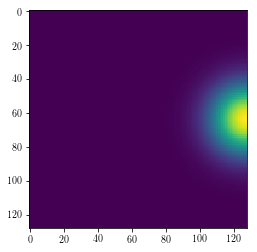

In [15]:
x0, y0 = (1, 0.)
x_range = np.linspace(-1, 1, num=n)
y_range = np.linspace(-1, 1, num=n)
rv = spstat.multivariate_normal([x0, y0], [[0.05, 0.0], [0.0, 0.05]])
x, y = np.meshgrid(x_range, y_range)
pos = np.dstack((x, y))
u0 = rv.pdf(pos)
plt.imshow(u0)
u0 = u0.reshape(n*n, 1)

In [16]:
ut, der = sai.expm_ArnoldiSAI2_der(A, u0.ravel(), stop, 0.07*stop, tol, 1000)

Computing sparse LU factorization of the SAI matrix...
j = 0, resnorm = 85.32564328880576
j = 1, resnorm = 123.5806824215539
j = 2, resnorm = 85.42399541498668
j = 3, resnorm = 45.34752187701549
j = 4, resnorm = 27.06803514535678
j = 5, resnorm = 15.27029083241096
j = 6, resnorm = 6.452607573734702
j = 7, resnorm = 1.951226566874675
j = 8, resnorm = 0.31246432039228683
j = 9, resnorm = 0.08297312987579512
j = 10, resnorm = 0.05411287944659051
j = 11, resnorm = 0.011664513221227931
j = 12, resnorm = 0.007354964734984568
j = 13, resnorm = 0.0018364179920959268
j = 14, resnorm = 0.0017106846414823584
j = 15, resnorm = 0.0005732185641599023
j = 16, resnorm = 0.0001752422730770895
j = 17, resnorm = 0.0002168948572280249
j = 18, resnorm = 5.598745986780236e-05
j = 19, resnorm = 2.9042706802929587e-05
j = 20, resnorm = 2.954037148106801e-05
j = 21, resnorm = 7.736550977199758e-06
j = 22, resnorm = 3.8874570746087105e-06
j = 23, resnorm = 4.3782318406233664e-06
j = 24, resnorm = 1.464587449267

In [17]:
print("Derivative estimation =", der)

Derivative estimation = -9.57802284267485e-07


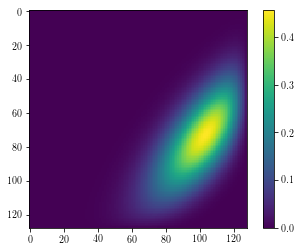

In [18]:
plt.imshow(ut.reshape(n, n))
plt.colorbar()

## Improve $\gamma$ for every next initial vector

In [19]:
delta_trial = 0.07
gamma0 = stop * delta_trial
tol = 1e-8
max_iter = 100

In [20]:
time_conv_gamma0 = [0.0]
conv_hist_base = []
A_lu = spsplin.splu(spsp.eye(A.shape[0], format="csc") + gamma0 * A)
for i in range(batch_size):
    if i % 20 == 0:
        print("Index of the processed initial vector =", i)
    u0 = U_test[:, i][:, np.newaxis]
    st = time.time()
    _, _, conv_base = sai.expm_ArnoldiSAI(A, u0, stop, gamma0, tol, max_iter, False, A_lu)
    time_conv_gamma0.append(time_conv_gamma0[-1] - st + time.time())
    conv_hist_base.append(len(conv_base[conv_base > 0]))

Index of the processed initial vector = 0
Index of the processed initial vector = 20
Index of the processed initial vector = 40
Index of the processed initial vector = 60
Index of the processed initial vector = 80
Index of the processed initial vector = 100
Index of the processed initial vector = 120
Index of the processed initial vector = 140
Index of the processed initial vector = 160
Index of the processed initial vector = 180
Index of the processed initial vector = 200
Index of the processed initial vector = 220
Index of the processed initial vector = 240
Index of the processed initial vector = 260
Index of the processed initial vector = 280


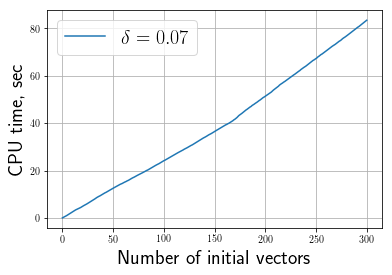

In [21]:
plt.plot(time_conv_gamma0, label="$\delta = {}$".format(delta_trial))
plt.grid(True)
plt.xlabel("Number of initial vectors", fontsize=20)
plt.ylabel("CPU time, sec", fontsize=20)
plt.legend(fontsize=20)

### Run incremental method

In [23]:
time_conv_opt = [0.0]
active_delta = []
low_delta = 0.01
up_delta = delta_trial
A_lu = None
conv_hist = []
for i in range(batch_size):
    current_delta = (low_delta + up_delta) * 0.5
    active_delta.append(current_delta)
    print("Batch index = {}".format(i))
    if np.abs(up_delta - low_delta) > 1e-5:
        print("Current delta = {}".format(current_delta))
        st = time.time()
        ut, der = sai.expm_ArnoldiSAI2_der(A, U_test[:, i], stop, current_delta * stop, tol, max_iter, disp=False)
        time_conv_opt.append(time_conv_opt[-1] - st + time.time())
        print("Sign of derivative estimation =", der / np.abs(der), ", derivative =", der)
        if der > 0:
            up_delta = current_delta
        else:
            low_delta = current_delta
    else:
        if A_lu is None:
            A_lu = spsplin.splu(spsp.eye(A.shape[0], format="csc") + current_delta * stop * A)
        st = time.time()
        _, _, conv_iter = sai.expm_ArnoldiSAI(A, U_test[:, i][:, np.newaxis], stop, current_delta * stop, tol, max_iter, False, A_lu)
        time_conv_opt.append(time_conv_opt[-1] - st + time.time())
        conv_hist.append(len(conv_iter[conv_iter > 0]))
        print("Average number of Arnoldi iterations =", np.mean(np.array(conv_hist)))

Batch index = 0
Current delta = 0.04
Sign of derivative estimation = 1.0 , derivative = 3.581409415378629e-05
Batch index = 1
Current delta = 0.025
Sign of derivative estimation = -1.0 , derivative = -1.116357954427571e-07
Batch index = 2
Current delta = 0.0325
Sign of derivative estimation = 1.0 , derivative = 7.451201414528814e-05
Batch index = 3
Current delta = 0.02875
Sign of derivative estimation = -1.0 , derivative = -0.00011650668958183383
Batch index = 4
Current delta = 0.030625
Sign of derivative estimation = -1.0 , derivative = -3.9521705387769e-05
Batch index = 5
Current delta = 0.0315625
Sign of derivative estimation = 1.0 , derivative = 3.950257176354265e-05
Batch index = 6
Current delta = 0.03109375
Sign of derivative estimation = -1.0 , derivative = -3.691982648753364e-06
Batch index = 7
Current delta = 0.031328125
Sign of derivative estimation = 1.0 , derivative = 2.9400925278754653e-05
Batch index = 8
Current delta = 0.0312109375
Sign of derivative estimation = -1.0 , 

Average number of Arnoldi iterations = 27.20212765957447
Batch index = 107
Average number of Arnoldi iterations = 27.189473684210526
Batch index = 108
Average number of Arnoldi iterations = 27.197916666666668
Batch index = 109
Average number of Arnoldi iterations = 27.20618556701031
Batch index = 110
Average number of Arnoldi iterations = 27.214285714285715
Batch index = 111
Average number of Arnoldi iterations = 27.22222222222222
Batch index = 112
Average number of Arnoldi iterations = 27.23
Batch index = 113
Average number of Arnoldi iterations = 27.207920792079207
Batch index = 114
Average number of Arnoldi iterations = 27.225490196078432
Batch index = 115
Average number of Arnoldi iterations = 27.203883495145632
Batch index = 116
Average number of Arnoldi iterations = 27.21153846153846
Batch index = 117
Average number of Arnoldi iterations = 27.228571428571428
Batch index = 118
Average number of Arnoldi iterations = 27.21698113207547
Batch index = 119
Average number of Arnoldi iter

Average number of Arnoldi iterations = 27.137254901960784
Batch index = 217
Average number of Arnoldi iterations = 27.141463414634146
Batch index = 218
Average number of Arnoldi iterations = 27.131067961165048
Batch index = 219
Average number of Arnoldi iterations = 27.14009661835749
Batch index = 220
Average number of Arnoldi iterations = 27.14423076923077
Batch index = 221
Average number of Arnoldi iterations = 27.148325358851675
Batch index = 222
Average number of Arnoldi iterations = 27.13809523809524
Batch index = 223
Average number of Arnoldi iterations = 27.137440758293838
Batch index = 224
Average number of Arnoldi iterations = 27.14622641509434
Batch index = 225
Average number of Arnoldi iterations = 27.154929577464788
Batch index = 226
Average number of Arnoldi iterations = 27.16355140186916
Batch index = 227
Average number of Arnoldi iterations = 27.167441860465118
Batch index = 228
Average number of Arnoldi iterations = 27.162037037037038
Batch index = 229
Average number of

### Compare CPU running time

Text(0, 0.5, 'CPU time, sec')

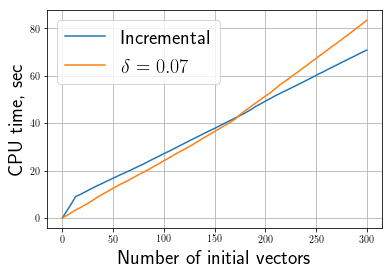

In [24]:
plt.plot(time_conv_opt, label="Incremental")
plt.plot(time_conv_gamma0, label="$\delta = " + str(delta_trial) + "$")
plt.legend(fontsize=20)
plt.grid(True)
plt.xlabel("Number of initial vectors", fontsize=20)
plt.ylabel("CPU time, sec", fontsize=20)

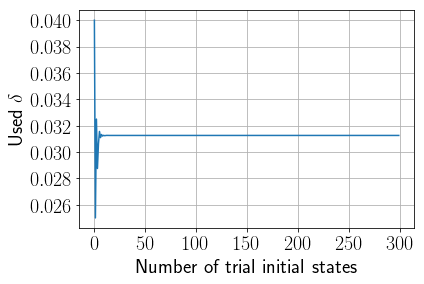

In [25]:
plt.plot(active_delta)
plt.xlabel("Number of trial initial states", fontsize=20)
plt.grid(True)
plt.ylabel("Used $\delta$", fontsize=20)
plt.yticks(fontsize=20)
_ = plt.xticks(fontsize=20)